# GFDL FLOR Historical

## Loads in all monthly forecasts of sea ice extent
## Regrids to polar stereographic,
## Saves to a netcdf file

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [28]:
# Data dir
data_dir = r'/home/disk/sipn/nicway/data/model/nmme/GFDL_FLORB01/hist/nomads.gfdl.noaa.gov'
data_out = r'/home/disk/sipn/nicway/data/model/nmme/GFDL_FLORB01/hist/stereo'

In [4]:
def preprocess_time(x):
    ''' Convert time to initialization and foreast lead time (to fit into orthoganal matrices)'''
    # Get initialization time
    x.coords['init_time'] = xr.decode_cf(x).isel(time=0).time.values;
    #     x.coords['init_time'].attributes
    # Get forecast time in days from initilization
    x.coords['time'] = np.arange(1,13,1)*30 - 15 # x.time.values.astype('timedelta64[D]').astype(int)
    # Rename and decode
    return x.rename({'time':'fore_time'}, inplace=True)

In [5]:
# Open a single ensemble member
def open_1_ensemble(cfiles, e):
    ds = xr.open_mfdataset(cfiles, concat_dim='init_time', decode_times=False, 
                           preprocess=lambda x: preprocess_time(x),
                           autoclose=True)
    ds.coords['ensemble'] = e
    return ds

In [9]:
# Open all ensemble members as a dataset
ds_list = []
for e in np.arange(1,13,1):
    ensm_name = 'r'+str(e)+'i1p1'
    cfiles = os.path.join(data_dir, '*sic*'+ensm_name+'*.nc')
    ds_list.append(open_1_ensemble(cfiles, e))
ds_all = xr.concat(ds_list, dim='ensemble')

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/conventions.py:1037: UserWarning: CF decoding is overwriting dtype on variable 'sic'
  .format(name))
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [31]:
ds_all.dims

Frozen(SortedKeysDict({'init_time': 83, 'ct': 5, 'bnds': 2, 'fore_time': 12, 'lon': 360, 'lat': 200, 'ensemble': 12}))

In [11]:
# Average over all sea ice categories 
sic = ds_all.sic.sum(dim='ct', skipna=False)

In [12]:
# Get info about target grid
flat = r'/home/disk/eos11/bitz/observations/seaice/data/psn25lats_v3.dat'
flon = r'/home/disk/eos11/bitz/observations/seaice/data/psn25lons_v3.dat'
NY=304; 
NX=448;

def readBinFile(f, nx, ny):
    with open(f, 'rb') as fid:
        data_array = np.fromfile(f, np.int32)*1e-5
    return data_array.reshape((nx,ny))

In [13]:
lat = readBinFile(flat, NX, NY).T
lon = readBinFile(flon, NX, NY).T
ds_out = xr.Dataset({'lat': (['y', 'x'],  lat), 'lon': (['y', 'x'], lon)})
ds_out

<xarray.Dataset>
Dimensions:  (x: 448, y: 304)
Dimensions without coordinates: x, y
Data variables:
    lat      (y, x) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (y, x) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


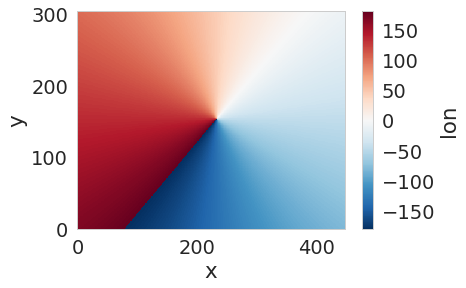

In [15]:
# Plot target lat and lon
ds_out.lon.plot.pcolormesh()

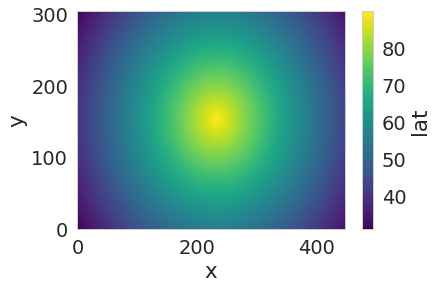

In [16]:
ds_out.lat.plot.pcolormesh()

In [17]:
# Calculate regridding matrix
regridder = xe.Regridder(sic, ds_out, 'bilinear', periodic=True)
# Regrid
sic_out = regridder(sic)
# sic_out

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: bilinear_200x360_304x448_peri.nc


In [30]:
sic_out.dims

('ensemble', 'init_time', 'fore_time', 'y', 'x')

In [19]:
# Define naive_fast that searches for the nearest WRF grid cell center
def naive_fast(latvar,lonvar,lat0,lon0):
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:]
    lonvals = lonvar[:]
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return iy_min,ix_min

In [22]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


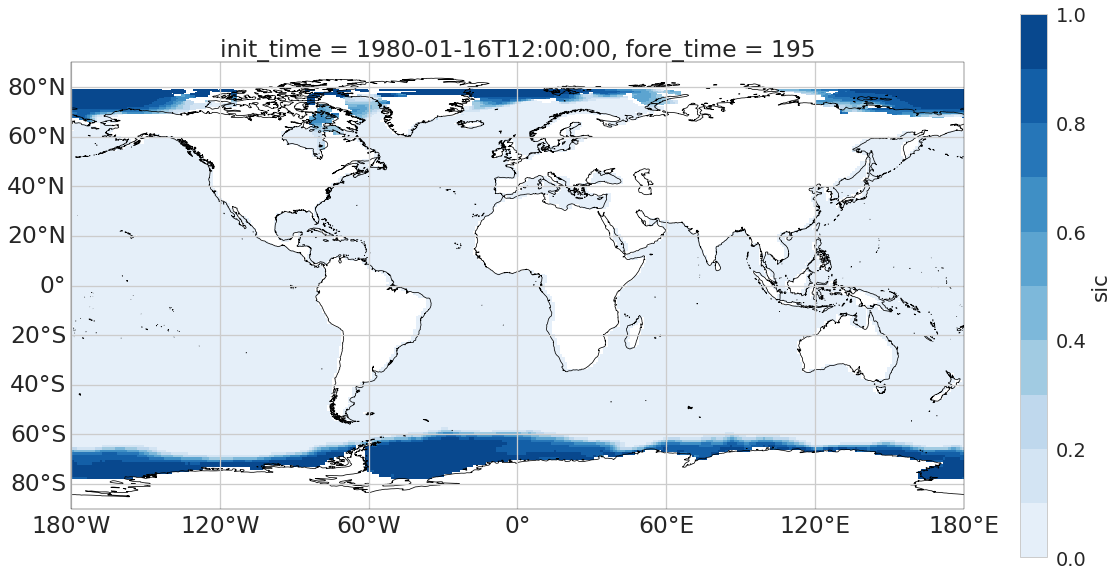

In [24]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
# ds_p = sic.mean(dim='init_time').mean(dim='fore_time').mean(dim='ensemble')
ds_p = sic.isel(init_time=0).isel(fore_time=6).mean(dim='ensemble')
ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=0, vmax=1,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)));
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

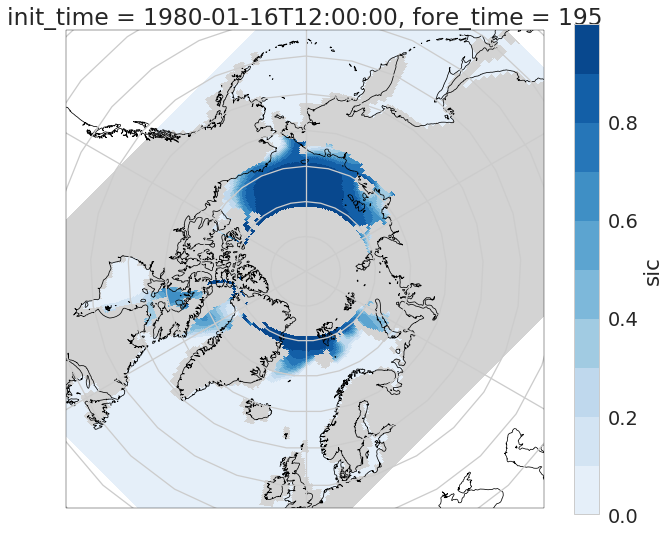

In [25]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
# ds_p2 = sic_out.mean(dim='init_time').mean(dim='fore_time').mean(dim='ensemble')
ds_p2 = sic_out.isel(init_time=0).isel(fore_time=6).mean(dim='ensemble')
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

In [29]:
# # Save regridded to netcdf file
f_out = os.path.join(data_out, 'GFDL_FLORB01_Stereo.nc')
sic_out.to_netcdf(f_out)

In [ ]:
# Clean up
regridder.clean_weight_file()  # clean-up